In [1]:
####
# Creator;Maintainer: Tamas Szuromi - tromika@gmail.com
####

In [42]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lifetimes import BetaGeoFitter
from lifetimes.utils import summary_data_from_transaction_data

In [11]:
data = pd.read_csv("../data/raw/training.csv")

In [12]:
data.columns.values

array(['order_id', 'contact_id', 'purchase_date', 'product_id', 'quantity',
       'sales_amount'], dtype=object)

In [26]:
data.dtypes

order_id                  int64
contact_id                int64
purchase_date    datetime64[ns]
product_id                int64
quantity                  int64
sales_amount            float64
dtype: object

In [25]:
data['purchase_date'] = pd.to_datetime(data['purchase_date'])

In [27]:
data.head()

,order_id,contact_id,purchase_date,product_id,quantity,sales_amount
0,4852169,17846335,2012-01-01,3308032,1,18.71
1,3570597,18759585,2012-01-01,37220513,2,83.50
2,32096674,5025194,2012-01-01,10259603,1,19.95
3,2904402,29624779,2012-01-01,3308032,1,18.71
4,38369470,42287117,2012-01-01,3308032,1,18.71


In [90]:
from sklearn.cluster import KMeans
dataCopy = data[['quantity','sales_amount']]
outliersModel = KMeans(n_clusters=2)
outliersModelFit = outliersModel.fit(dataCopy)

In [93]:
dataClustered = dataCopy
dataClustered['cluster'] = outliersModel.predict(dataCopy)

In [95]:
dataClustered[dataClustered.cluster == 1]

,quantity,sales_amount,cluster
8,1,239.95,1
36,1,324.28,1
37,1,321.43,1
47,1,195.95,1
60,1,207.95,1
62,1,199.95,1
105,1,297.00,1
139,4,199.60,1
149,1,233.95,1
173,1,199.95,1


In [28]:
inputData = data.groupby(['contact_id', 'order_id'])

In [31]:
summary = summary_data_from_transaction_data(data, 'contact_id', 'purchase_date', observation_period_end='2013-12-31')

In [52]:
summary.head()

,frequency,recency,T
contact_id,,,
17846335,1.0,400.0,730.0
18759585,0.0,0.0,730.0
5025194,260.0,624.0,730.0
29624779,5.0,315.0,730.0
42287117,2.0,546.0,730.0


In [34]:
summary.columns.values

array(['frequency', 'recency', 'T'], dtype=object)

In [36]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
print bgf

<lifetimes.BetaGeoFitter: fitted with 262295 subjects, a: 1.00, alpha: 45.64, b: 1.54, r: 0.11>


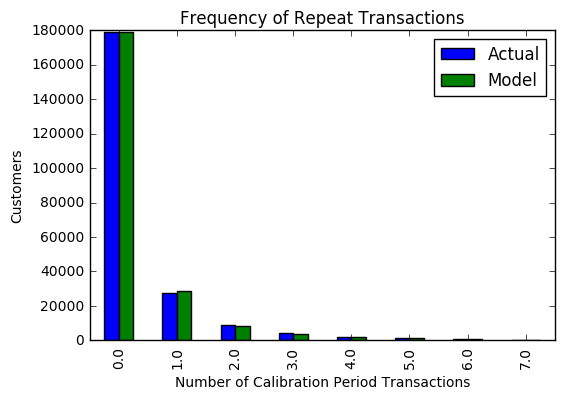

In [44]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [82]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(data, 'contact_id', 'purchase_date', 
                                        calibration_period_end='2012-12-31',
                                        observation_period_end='2013-12-31' )   
print summary_cal_holdout.head()

            frequency_cal  recency_cal  T_cal  frequency_holdout  \
contact_id                                                         
17846335              0.0          0.0  365.0                1.0   
18759585              0.0          0.0  365.0                0.0   
5025194             240.0        361.0  365.0               20.0   
29624779              5.0        315.0  365.0                0.0   
42287117              1.0         41.0  365.0                1.0   

            duration_holdout  
contact_id                    
17846335                 365  
18759585                 365  
5025194                  365  
29624779                 365  
42287117                 365  


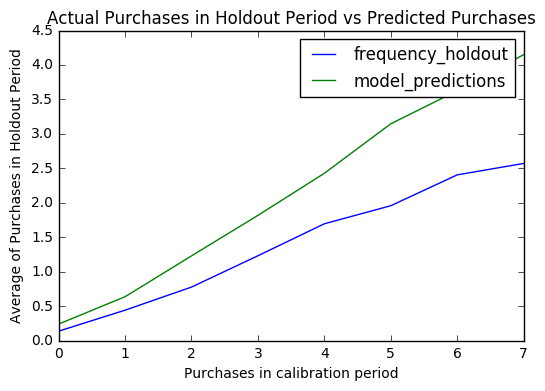

In [83]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [55]:
summary_with_monetary = summary.join(data.groupby(['contact_id']).agg({'sales_amount':np.sum}))

In [78]:
summary_with_monetary = summary_with_monetary[summary_with_monetary.sales_amount>0]

In [79]:
summary_with_monetary[['sales_amount', 'frequency']].corr()

,sales_amount,frequency
sales_amount,1.000000,0.861322
frequency,0.861322,1.000000


In [61]:
returning_customers_summary = summary_with_monetary[summary_with_monetary['frequency']>0]

In [62]:
returning_customers_summary[['sales_amount', 'frequency']].corr()

,sales_amount,frequency
sales_amount,1.000000,0.870428
frequency,0.870428,1.000000


In [84]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0.0001)
ggf.fit(summary_with_monetary['frequency'],
        summary_with_monetary['sales_amount'])
print ggf  

<lifetimes.GammaGammaFitter: fitted with 262293 subjects, p: 14.41, q: 1.63, v: 15.24>


In [85]:
print "Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary_with_monetary['frequency'],
        summary_with_monetary['sales_amount']
    ).mean(),
    summary_with_monetary[summary_with_monetary['frequency']>0]['sales_amount'].mean()
)

Expected conditional average profit: 341.287118195, Average profit: 310.136910581


In [74]:
summary_with_monetary['sales_amount'].mean()

137.6061403380168

In [87]:
bgf.fit(summary_with_monetary['frequency'], summary_with_monetary['recency'], summary_with_monetary['T'])

print ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary_with_monetary['frequency'],
    summary_with_monetary['recency'],
    summary_with_monetary['T'],
    summary_with_monetary['sales_amount'],
    time=12 # monthly discount rate ~ 12.7% annually
).head(10)

contact_id
17846335    8.763144e+00
18759585    1.568698e+01
5025194     2.018110e-08
29624779    4.018073e+01
42287117    2.599266e+02
34476502    1.568698e+01
14603912    1.568698e+01
10412066    2.654101e+02
35117040    2.390445e+07
38480502    1.568698e+01
Name: clv, dtype: float64
